In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
import numpy as np
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font='serif')
sns.set_context("paper", font_scale=2.5)

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.preprocess_lib import *
import src.testing_lib as testing_lib

### Find the desired model

In [4]:
config_dir = '/home/kbolat/Python/behavio-temporal-vae/runs/sweep_runs_corrected/sweep_Sep21_20-43-56'
config_file = 'config.json'
save_dir = 'transfer'

with open(os.path.join(config_dir, config_file), 'r') as f: config = json.load(f)

In [5]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=10
Mean of enrolments: 28.59
Number of Training Points...............1377166
Number of Testing Points................459055
Number of Validation Points.............459055
Number of Missing Points................197674
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_1


### Pattern dictionary

In [6]:
# Load model
model = CVAE(input_dim=valset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(config_dir)

USING SIGMA_LIM!
USING MARGINAL_STD_LIM!
USING SIGMA_LIM!
USING MARGINAL_STD_LIM!


## User dictionary

In [7]:
import pickle as pkl
with open("/home/kbolat/Python/behavio-temporal-vae/data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_11/model.pkl", "rb") as f:
    user_model = pkl.load(f)

In [10]:
user_model.doc_lengths

array([363., 365., 354., ..., 314., 353., 363.])

In [8]:
user_gamma = np.load("/home/kbolat/Python/behavio-temporal-vae/data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_30/user_gamma.npy")

NameError: name 'save_dir' is not defined

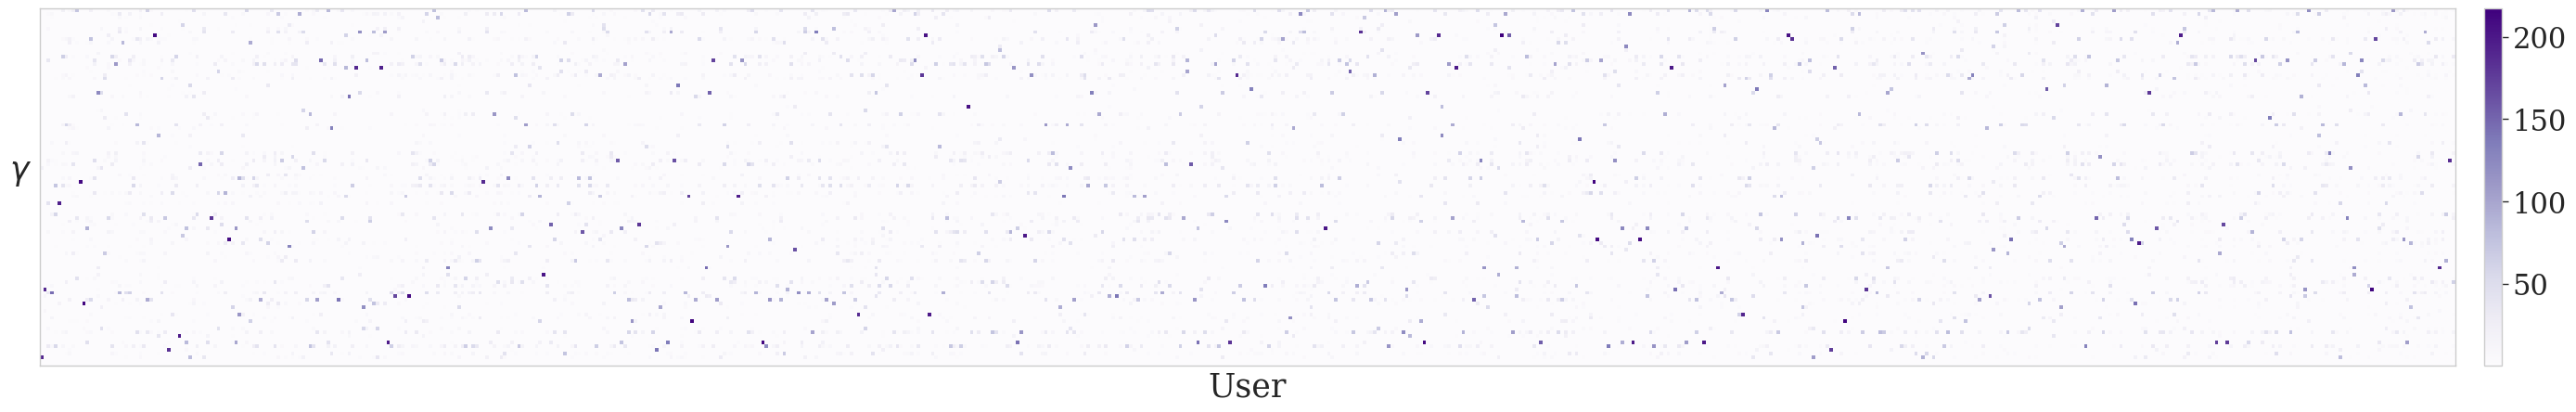

In [9]:
ssample = 10 ## for visualization
fig, ax = plt.subplots(figsize=(40, 5))
plt.pcolormesh(user_gamma[9::ssample].T, cmap='Purples')
ax.set_xlabel("User", size=25)
ax.set_ylabel(r"$\gamma$", size=25, rotation=0, labelpad=15)
plt.xticks([])
plt.yticks([])
plt.colorbar(pad=0.01)

if os.path.exists(save_dir): 
    plt.savefig(os.path.join(save_dir, f'user_gamma.png'), bbox_inches='tight', dpi=300, pad_inches=0)

plt.show()

In [123]:
theta_mean = user_gamma / np.sum(user_gamma, axis=1, keepdims=True)

In [119]:
def clr_transformation(data):
    """
    Apply Centered Log-Ratio (CLR) transformation to compositional data.
    """
    geometric_mean = np.exp(np.mean(np.log(data), axis=1, keepdims=True))
    clr_data = np.log(data / geometric_mean)
    return clr_data

In [120]:
def ilr_transformation(data):
    """
    Apply Isometric Log-Ratio (ILR) transformation to compositional data.
    """
    n_samples, n_features = data.shape
    ilr_data = np.zeros((n_samples, n_features - 1))
    
    # Create the Helmert matrix
    helmert_matrix = np.zeros((n_features - 1, n_features))
    for i in range(1, n_features):
        helmert_matrix[i-1, :i] = -1 / i
        helmert_matrix[i-1, i] = i

    # Normalize the Helmert matrix
    helmert_matrix = helmert_matrix / np.sqrt(np.arange(1, n_features) * np.arange(2, n_features + 1))[:, np.newaxis]

    # Apply the ILR transformation
    for i in range(n_samples):
        ilr_data[i, :] = np.dot(helmert_matrix, np.log(data[i, :]))

    return ilr_data

In [185]:
theta_transformed = ilr_transformation(theta_mean)

In [186]:
## apply pca to the clr transformed data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
theta_pca = pca.fit_transform(clr_transformation(theta_mean))



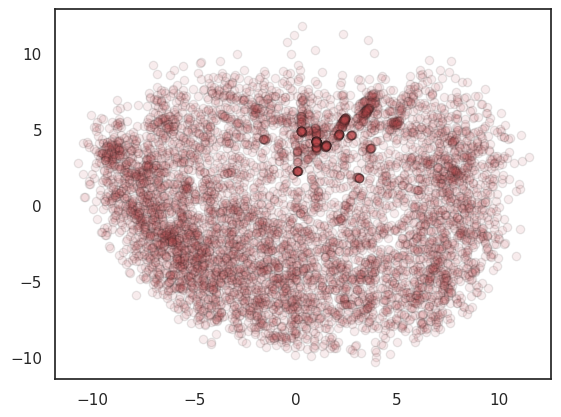

In [187]:
plt.scatter(theta_pca[:,0], theta_pca[:,1], alpha=0.1, c='r', linewidths=0.9, edgecolors='k')

In [188]:
## apply t-SNE to the transformed data
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
theta_tsne = tsne.fit_transform(theta_transformed)


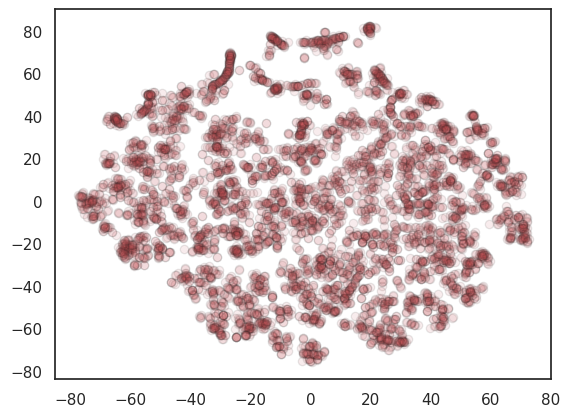

In [189]:
plt.scatter(theta_tsne[:,0], theta_tsne[:,1], alpha=0.1, c='r', linewidths=0.9, edgecolors='k')